In [4]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
def load_data(file_name):
    curr_file = os.path.join(os.getcwd().replace('eda', 'data'), file_name)
    return pd.read_csv(curr_file, delimiter=",")

# Reload the dataset with the correct delimiter
data = load_data('data.csv')

# Display the first few rows of the dataset
data.head()


,colesterol_total,idade,glicemia,Outcome
0,0.822587,-1.095509,0.714817,-1
1,-0.881201,-1.203114,1.526760,-1
2,-1.106230,-0.934102,-0.945975,-1
3,0.661852,0.787579,-1.093601,-1
4,0.886880,1.863630,-1.056695,1


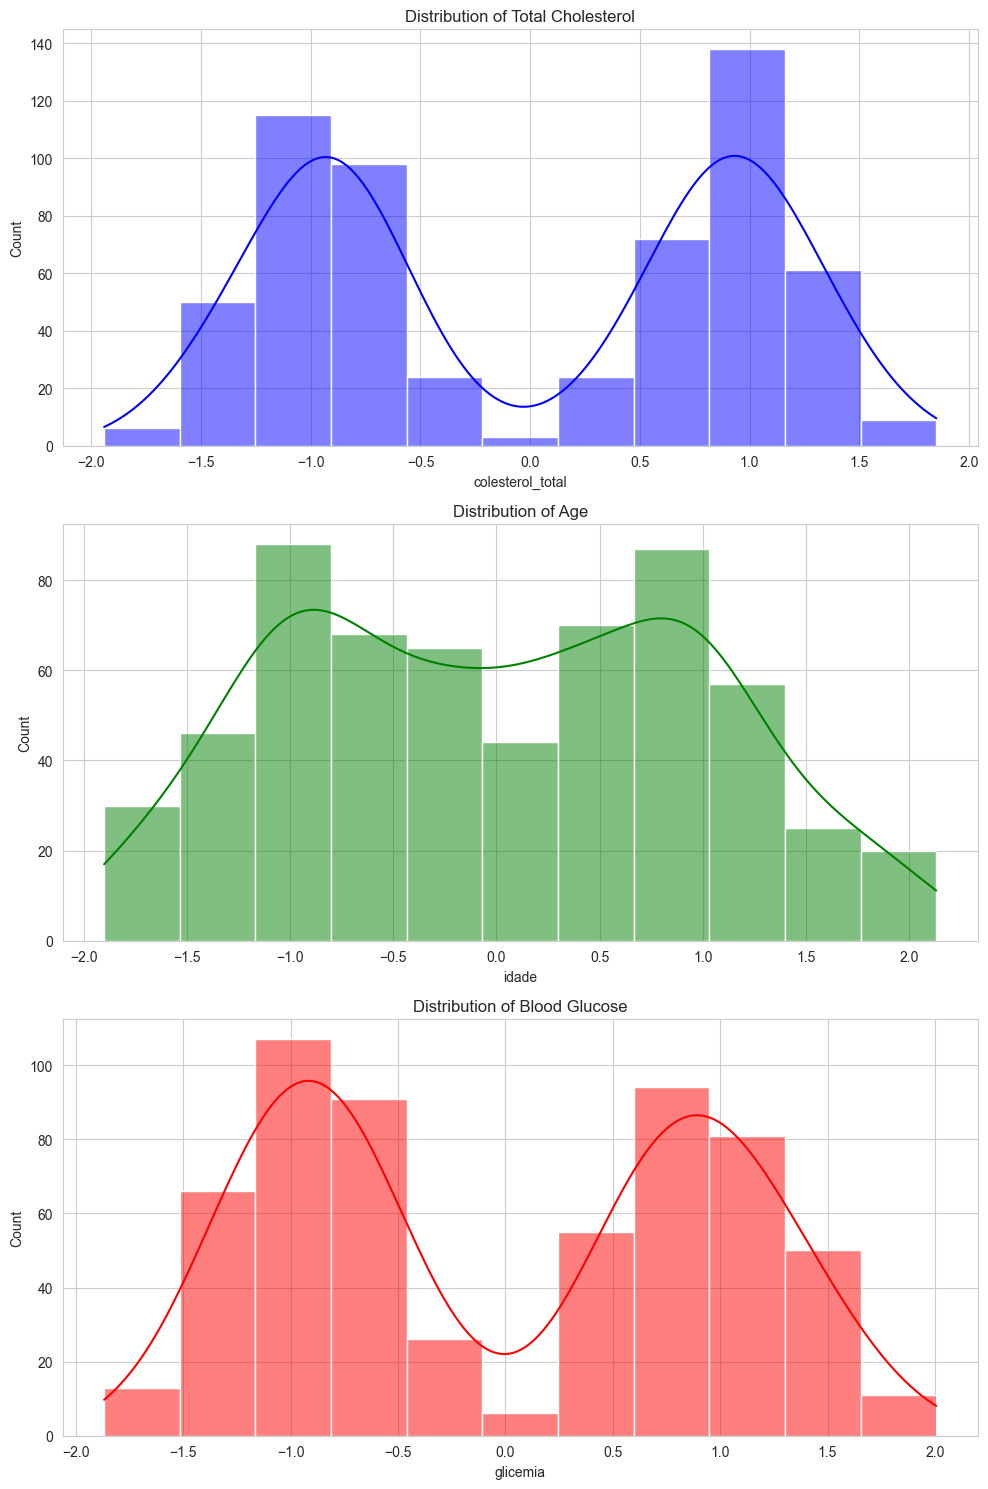

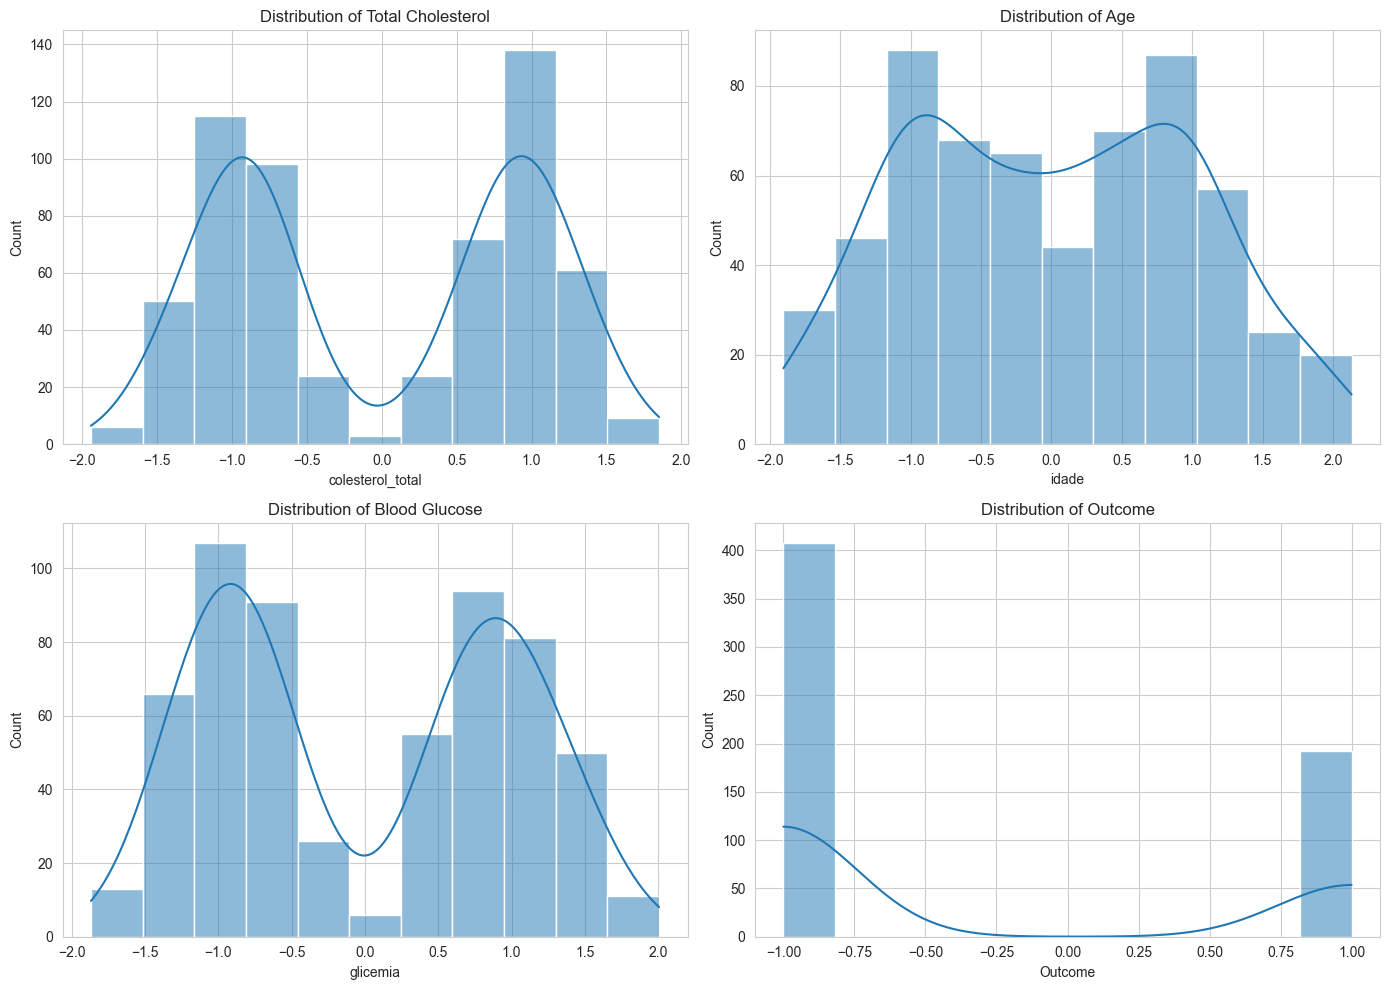

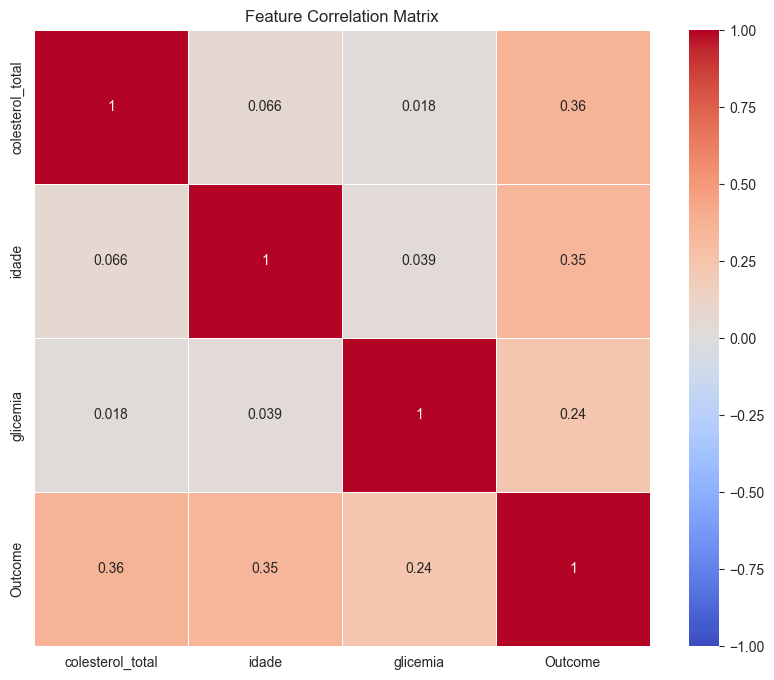

In [6]:

# Set the style for the plots
sns.set_style("whitegrid")

# Create a figure with subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Plot distributions of the numerical features
sns.histplot(data=data, x="colesterol_total", kde=True, ax=axs[0], color="blue").set_title("Distribution of Total Cholesterol")
sns.histplot(data=data, x="idade", kde=True, ax=axs[1], color="green").set_title("Distribution of Age")
sns.histplot(data=data, x="glicemia", kde=True, ax=axs[2], color="red").set_title("Distribution of Blood Glucose")

# Adjust the layout
plt.tight_layout()
plt.show()

# Set up the figure and axes
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Plot histograms for colesterol_total, idade, and glicemia
sns.histplot(data['colesterol_total'], kde=True, ax=ax[0, 0]).set_title('Distribution of Total Cholesterol')
sns.histplot(data['idade'], kde=True, ax=ax[0, 1]).set_title('Distribution of Age')
sns.histplot(data['glicemia'], kde=True, ax=ax[1, 0]).set_title('Distribution of Blood Glucose')

# Plot a bar plot for desfecho
sns.histplot(data['Outcome'], kde=True, ax=ax[1, 1]).set_title('Distribution of Outcome')

# Adjust layout
plt.tight_layout()
plt.show()

# Check for missing values in the dataset
missing_values = data.isnull().sum()
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=.5)
plt.title("Feature Correlation Matrix")
plt.show()